In [1]:
import requests
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from skimage.util import montage
import cv2


In [2]:
image_path = "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/"

# Lista de frutas e URLs correspondentes
fruits_and_urls = [
    ("Apple", image_path + "Apple.tar.gz"),
    ("Banana", image_path + "Banana.tar.gz"),
    ("Banana", image_path + "Banana_2.tar.gz"),
    ("Clementine", image_path + "Clementine.tar.gz"),
    ("Lemon", image_path + "Lemon.tar.gz"),
    ("Papaya", image_path + "Papaya.tar.gz"),
    ("Pear", image_path + "Pear.tar.gz"),
    ("Pineapple", image_path + "Pineapple.tar.gz"),
    ("Strawberry", image_path + "Strawberry.tar.gz"),
    ("Tomato", image_path + "Tomato.tar.gz"),
    ("Coconut", image_path + "Coconut.tar.gz"),
]

In [29]:
Image_height = 1000
Image_width = 1000
Image_channels = 4
Number_of_images = 80
Current_number_of_images = 0
class_images = {}

White_image = np.full((Image_height, Image_width, Image_channels), 255, dtype=np.uint8)

def download_and_extract(github_url, folder_name):
    # Cria o diretório se não existir
    os.makedirs(folder_name, exist_ok=True)

    # Baixa o arquivo tar.gz
    response = requests.get(github_url)
    tar_data = BytesIO(response.content)

    # Extrai o conteúdo do arquivo tar.gz
    with tarfile.open(fileobj=tar_data, mode="r:gz") as tar:
        tar.extractall(path=folder_name)

def process_fruit_images(folder_name, class_images):
    ############ Current_number_of_images = 0

    # Lista os arquivos na pasta extraída
    extracted_files = []
    for root, dirs, files in os.walk(folder_name):
        for file_name in files:
            extracted_files.append(os.path.join(root, file_name))

    # Ordena a lista de arquivos por nome
    extracted_files.sort()

    # Adiciona as imagens à lista correspondente à classe
    class_images[folder_name] = []

    for file_path in extracted_files:
        image = Image.open(file_path)
        image_array = np.array(image)

        # Verifica a forma da imagem
        if len(image_array.shape) == 3 and image_array.shape[2] == 3:
            # Adiciona um canal alfa (255) para imagens RGB (3 canais)
            image_array = np.concatenate([image_array, np.ones_like(image_array[:, :, :1]) * 255], axis=-1)
            class_images[folder_name].append(image_array)
        else:
            # Mantém as imagens que já têm um canal alfa (4 canais)
            class_images[folder_name].append(image_array)

        if(image_array.shape[0] != 1000):
            print(file_path)
            print((image_array.shape))

# Processa cada fruta
for fruit, url in fruits_and_urls:
    download_and_extract(url, fruit)
    process_fruit_images(fruit, class_images)



10

In [31]:
def create_montage(classimages, Height_size, Length_size, Lines, Columns):
    images_list = []
    for class_fruit, images in classimages.items():
        images_list.extend(images)

    Montage = montage(images_list, grid_shape=(Lines, Columns), channel_axis=-1)

    # Exiba a montagem
    plt.figure(figsize=(Height_size, Length_size))
    plt.imshow(Montage)
    plt.axis('off')
    plt.show()

half = len(class_images) // 2
items = list(class_images.items())

list1 = dict(items[:half])
list2 = dict(items[half:])

create_montage(list1, 15, 30, 4*len(list1), 20)
create_montage(list2, 15, 30, 4*len(list2), 20)

10


4 - Data normalization

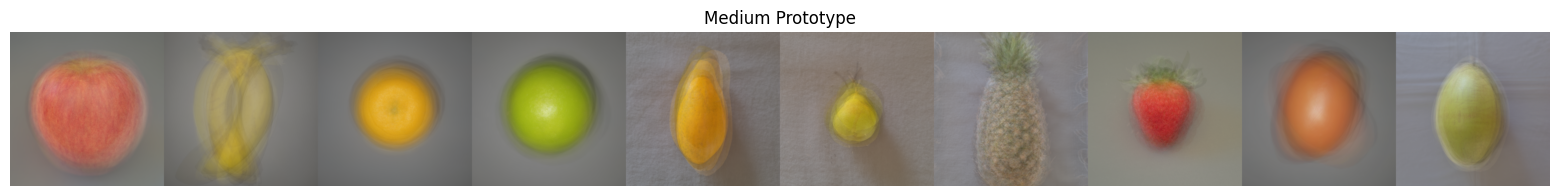

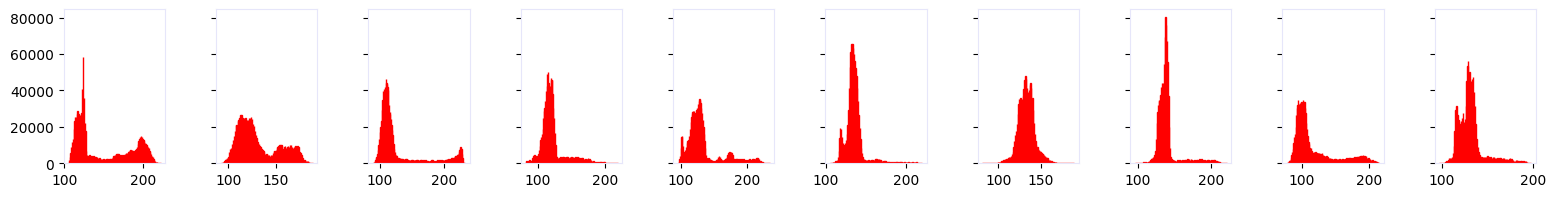

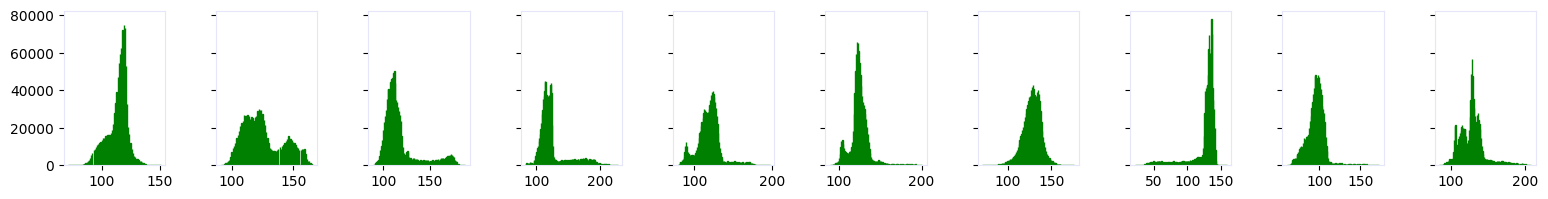

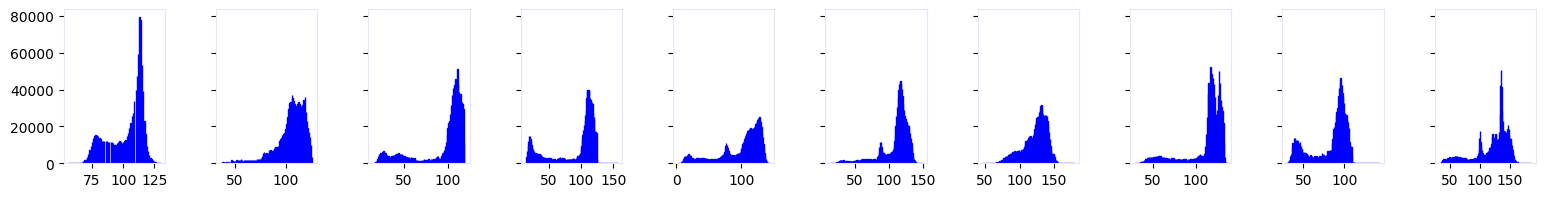

In [34]:
def get_medium_prototypes():
    mean_images = {}
    for class_fruit, images in class_images.items():
        
        mean_image = np.mean(images, axis=0)
        mean_images[class_fruit] = mean_image.astype('uint8')

    return np.array(list(mean_images.values()))

def get_image_histograms(array):
    red_channel_histograms = []
    blue_channel_histograms = []
    green_channel_histograms = []

    for img in array:
      counts,bins = np.histogram(img[:,:,0], 255)
      red_channel_histograms.append((counts,bins))

      counts,bins = np.histogram(img[:,:,1], 255)
      green_channel_histograms.append((counts,bins))

      counts,bins = np.histogram(img[:,:,2], 255)
      blue_channel_histograms.append((counts,bins))

    return red_channel_histograms, blue_channel_histograms, green_channel_histograms

def show_histograms(histograms, edge_color):
    fig, axes = plt.subplots(1, 10, figsize=(19, 2), sharey=True, gridspec_kw={'wspace': 0.5})
    ax = axes.ravel()
    i = 0
    for histogram in histograms:
        counts, bins = histogram
        ax[i].bar(bins[:-1], counts, width=np.diff(bins), edgecolor=edge_color)
        i += 1

    plt.show()

medium_images = get_medium_prototypes()

#montage com as imagens médias
Montage = montage(medium_images, grid_shape=(1, 10), channel_axis=-1)

plt.figure(figsize=(25, 2))
plt.title('Medium Prototype')
plt.imshow(Montage)
plt.axis('off')
plt.show()

r_medium_histograms, b_medium_histograms, g_medium_histograms = get_image_histograms(medium_images)

show_histograms(r_medium_histograms, 'red')
show_histograms(g_medium_histograms, 'green')
show_histograms(b_medium_histograms, 'blue')




6 - Treinamento e Classificação

6.1 - Treinamento

Obtendo o dataset na forma correta

In [16]:
def get_images_and_targets():
  images_and_targets = []
  i = 0
  for fruit_class, imgs in class_images.items():
    for img in imgs:
      images_and_targets.append((img[:,:,:-1], get_class_id(fruit_class)))
      i += 1

  images, targets = zip(*images_and_targets)
  images = np.array(images)
  targets = np.array(targets)
  return images, targets

def get_class_id(classname):
  match classname:
    case 'Banana':
      return 0
    case 'Clementine':
      return 1
    case 'Lemon':
      return 2
    case 'Tomato':
      return 3
    case 'Strawberry':
      return 4
    case 'Apple':
      return 5
    case 'Pineapple':
      return 6
    case 'Pear':
      return 7
    case 'Papaya':
      return 8
    case 'Coconut':
      return 9

images, targets = get_images_and_targets()

resized_images = []

for img in images:
  resized_images.append(cv2.resize(img, (300, 300)))

resized_images = np.array(resized_images)

Particionamento de dados para treinamento e teste

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(resized_images, targets, test_size = 0.2, shuffle=True)

print(f'Train data -> type:{type(X_train)} shape:{X_train.shape} size:{X_train.size}\n')
print(f'Test data  -> type:{type(X_test)} shape:{X_test.shape} size:{X_test.size}\n')


Train data -> type:<class 'numpy.ndarray'> shape:(537, 300, 300, 3) size:144990000

Test data  -> type:<class 'numpy.ndarray'> shape:(135, 300, 300, 3) size:36450000



In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Carregando o modelo ResNet50 sem a camada densa (incluindo o topo)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Congelando as camadas convolucionais pré-treinadas
for layer in base_model.layers:
    layer.trainable = False

# Adicionando camadas personalizadas ao topo do modelo
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 classes de frutas

# Compile o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Convertendo y_train e y_test para o formato "one-hot"
y_train_categorical = to_categorical(y_train, num_classes=10)  
y_test_categorical = to_categorical(y_test, num_classes=10)    

# Treinamento do modelo
history = model.fit(
    X_train,
    y_train_categorical,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test_categorical)
)

Epoch 1/5
17/17 [==============================] - 39s 2s/step - loss: 1.8648 - accuracy: 0.4041 - val_loss: 1.1661 - val_accuracy: 0.7037
Epoch 2/5
17/17 [==============================] - 35s 2s/step - loss: 0.8298 - accuracy: 0.8566 - val_loss: 0.5085 - val_accuracy: 0.9481
Epoch 3/5
17/17 [==============================] - 34s 2s/step - loss: 0.4114 - accuracy: 0.9683 - val_loss: 0.2950 - val_accuracy: 0.9630
Epoch 4/5
17/17 [==============================] - 35s 2s/step - loss: 0.2378 - accuracy: 0.9795 - val_loss: 0.1764 - val_accuracy: 0.9852
Epoch 5/5
17/17 [==============================] - 35s 2s/step - loss: 0.1626 - accuracy: 0.9888 - val_loss: 0.1428 - val_accuracy: 0.9778


In [27]:
model.evaluate(X_test, y_test_categorical)

5/5 [==============================] - 7s 1s/step - loss: 0.1428 - accuracy: 0.9778


[0.142759308218956, 0.9777777791023254]

1/1 [==============================] - 1s 1s/step


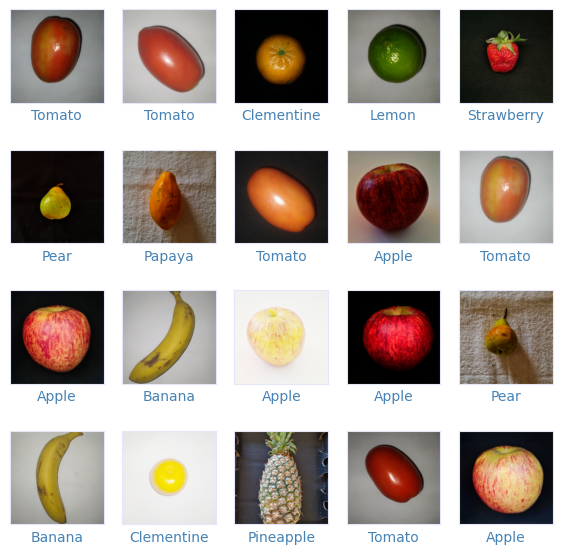

In [36]:
classes = ['Banana', 'Clementine', 'Lemon', 'Tomato', 'Strawberry', 'Apple', 'Pineapple', 'Pear', 'Papaya', 'Coconut']

X_result = X_test[:20]

predictions = model.predict(X_result)

y_pred = np.argmax(predictions, axis=1)

classes_predicted = [classes[i] for i in y_pred]

plt.rc('axes',edgecolor='lavender')

fig = plt.figure(figsize=(7, 7))

for i in range(20):
    plt.subplot(4, 5, i + 1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_result[i], cmap=plt.cm.binary)
    plt.xlabel(classes_predicted[i], color='steelblue')

plt.show()

5/5 [==============================] - 7s 1s/step
Accuracy:0.98



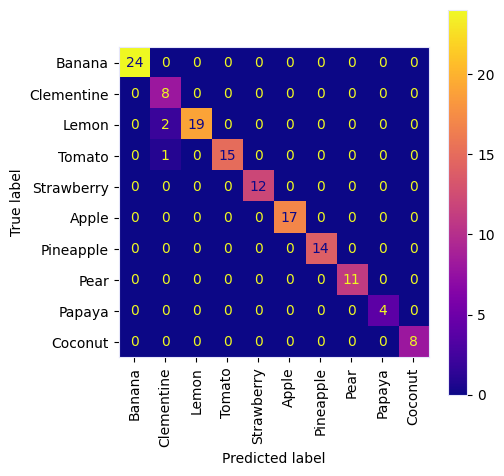

In [37]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy:{accuracy:.2f}\n')

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=classes, xticks_rotation="vertical",
    ax=ax, colorbar=True, cmap="plasma")

plt.show()